In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# https://docs.opencv.org/3.4/d4/d1f/tutorial_pyramids.html
# https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_pyramids/py_pyramids.html

class MergeLayerC(nn.Module):
    
    def __init__(self):
        super(MergeLayerC, self).__init__()
        self.conv0 = nn.Conv2d(8, 4, 15, padding = 7, bias=False)
        
        self.conv1 = nn.Conv2d(4, 4, 3, stride = 2, bias=False) #padding left to F.pad
        self.conv2 = nn.Conv2d(4, 4, 3, stride = 2, bias=False)
        self.conv3 = nn.Conv2d(4, 4, 3, stride = 2, bias=False)
        self.upconv1 = nn.ConvTranspose2d(4, 4, 2, stride = 2, bias=False) 
        self.upconv2 = nn.ConvTranspose2d(4, 4, 2, stride = 2, bias=False) 
        self.upconv3 = nn.ConvTranspose2d(4, 4, 2, stride = 2, bias=False) 
        
    def gauss_pyramid(self, x):
        G = x.clone()
        gp = [G]
        x = self.conv1(F.pad(x, (0, 1, 0, 1), mode = 'reflect'))
        gp.append(x)
        x = self.conv2(F.pad(x, (0, 1, 0, 1), mode = 'reflect'))
        gp.append(x)
        x = self.conv3(F.pad(x, (0, 1, 0, 1), mode = 'reflect'))
        gp.append(x)
        
        return gp
    
    def lap_pyramid(self, x):
        gp = self.gauss_pyramid(x)
        lp = [gp[-1]]
        GE = self.upconv1(gp[-1])
        L = gp[-2] - GE
        lp.append(L)
        GE = self.upconv2(gp[-2])
        L = gp[-3] - GE
        lp.append(L)
        GE = self.upconv3(gp[-3])
        L = gp[-4] - GE
        lp.append(L)
        return lp
        
    
    def forward(self, x):
        ## x size: (batch_size, 4(rggb)*2, H//2, W//2)
        mm = (torch.sum(torch.abs(self.conv0(x)), dim = 1) - 500.0).repeat(1, 4, 1, 1)
        mask = torch.sigmoid(mm)
        ref = x[:, :4]
        alt = x[:, 4:]
        lp_ref = self.lap_pyramid(ref)
        lp_alt = self.lap_pyramid(alt)
        gp_mask = [mask, F.max_pool2d(mask, 2), F.max_pool2d(F.max_pool2d(mask, 2), 2), 
                   F.max_pool2d(F.max_pool2d(F.max_pool2d(mask, 2), 2), 2)]#self.gauss_pyramid(mask)
        
        LS = []
        for la,lb,mask in zip(lp_ref,lp_alt, gp_mask[::-1]):
            ls = la * mask + lb * (1.0 - mask)
            LS.append(ls)
        
        ls_ = LS[0]
        ls_ = self.upconv1(ls_)
        ls_ = ls_ + LS[1]
        ls_ = self.upconv2(ls_)
        ls_ = ls_ + LS[2]
        ls_ = self.upconv3(ls_)
        ls_ = ls_ + LS[3]
        
        return ls_, mask

In [3]:
def print_model_params(model):
    print("#total params:", sum(p.numel() for p in model.parameters()), end='')
    print(" | #trainable params:", sum(p.numel() for p in model.parameters() if p.requires_grad))
    
model = MergeLayerC().cuda()
print_model_params(model)

#total params: 7824 | #trainable params: 7824


In [4]:
# inputs = torch.rand(3, 8, 1024, 1792) * 2.0 - 1.0
# outputs = model(inputs)
# outputs.size()

In [5]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [6]:
for epoch in range(2):  # loop over the dataset multiple times

    # get the inputs; data is a list of [inputs, labels]
    inputs = torch.rand(1, 8, 1024, 1792).cuda()
    labels = torch.rand(1, 4, 1024, 1792).cuda()

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs, _ = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()


print('Finished Training')

Finished Training


In [7]:
gauss_kernel = [[0.00390625,0.0234375,0.00390625],[0.0234375,0.140625,0.0234375],[0.00390625,0.0234375,0.00390625]]
gauss_kernel = torch.FloatTensor(gauss_kernel).unsqueeze(0)
kernel1 = torch.cat([gauss_kernel, torch.zeros(3, 3, 3)], dim = 0)
kernel2 = torch.cat([torch.zeros(1, 3, 3), gauss_kernel, torch.zeros(2, 3, 3)], dim = 0)
kernel3 = torch.cat([torch.zeros(2, 3, 3), gauss_kernel, torch.zeros(1, 3, 3)], dim = 0)
kernel4 = torch.cat([torch.zeros(3, 3, 3), gauss_kernel], dim = 0)
conv_weight = torch.stack([kernel1, kernel2, kernel3, kernel4], dim = 0)
conv_weight.size()

torch.Size([4, 4, 3, 3])

In [8]:
model.conv1.weight = torch.nn.Parameter(conv_weight.clone().cuda())
model.conv2.weight = torch.nn.Parameter(conv_weight.clone().cuda())
model.conv3.weight = torch.nn.Parameter(conv_weight.clone().cuda())

In [9]:
upkernel1 = torch.cat([torch.ones(1, 2, 2), torch.zeros(3, 2, 2)], dim = 0)
upkernel2 = torch.cat([torch.zeros(1, 2, 2), torch.ones(1, 2, 2), torch.zeros(2, 2, 2)], dim = 0)
upkernel3 = torch.cat([torch.zeros(2, 2, 2), torch.ones(1, 2, 2), torch.zeros(1, 2, 2)], dim = 0)
upkernel4 = torch.cat([torch.zeros(3, 2, 2), torch.ones(1, 2, 2)], dim = 0)
upconv_weight = torch.stack([upkernel1, upkernel2, upkernel3, upkernel4], dim = 0)
upconv_weight.size()

torch.Size([4, 4, 2, 2])

In [10]:
model.upconv1.weight = torch.nn.Parameter(upconv_weight.clone().cuda())
model.upconv2.weight = torch.nn.Parameter(upconv_weight.clone().cuda())
model.upconv3.weight = torch.nn.Parameter(upconv_weight.clone().cuda())

In [11]:
conv0_k1 = torch.zeros(8, 15, 15)
conv0_k1[0] += 1.0
conv0_k1[4] -= 1.0
conv0_k2 = torch.zeros(8, 15, 15)
conv0_k2[1] += 1.0
conv0_k2[5] -= 1.0
conv0_k3 = torch.zeros(8, 15, 15)
conv0_k3[2] += 1.0
conv0_k3[6] -= 1.0
conv0_k4 = torch.zeros(8, 15, 15)
conv0_k4[3] += 1.0
conv0_k4[7] -= 1.0
conv0_weight = torch.stack([conv0_k1, conv0_k2, conv0_k3, conv0_k4], dim = 0)
conv0_weight.size()

torch.Size([4, 8, 15, 15])

In [12]:
model.conv0.weight = torch.nn.Parameter(conv0_weight.cuda())

In [13]:
import sys
sys.path.append("../")
from utils import *
sys.path.append("../Google_HDRplus/")
from merge_utils import *
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
bk_lvl = 50
print("black level of the sensor: ", bk_lvl)

black level of the sensor:  50


In [15]:
rIm=read_raw("../static_videos/lowlight3_frame16_bunny_3.raw", frame =16)
rIm = rIm[:, :2048, :3584]

In [16]:
ref = rIm[0]
alt = np.load('../flow_test/warped_npys_lowlight3_bunny3/warped_15.npy')

assert ref.shape == alt.shape
assert ref.dtype == alt.dtype

In [17]:
ref_stack = raw_to_stack(ref)
alt_stack = raw_to_stack(alt)

In [18]:
ref_t = torch.from_numpy(ref_stack.copy().transpose(2, 0, 1))
alt_t = torch.from_numpy(alt_stack.copy().transpose(2, 0, 1))

In [19]:
inputs = torch.cat([ref_t, alt_t], dim = 0).unsqueeze(0)
inputs.size()

torch.Size([1, 8, 1024, 1792])

In [20]:
outputs, mask_t = model(inputs.float().cuda())

In [21]:
outputs.size()

torch.Size([1, 4, 1024, 1792])

In [22]:
img = outputs[0].detach().cpu().numpy().transpose(1, 2, 0)
img = stack_to_raw(img)

In [23]:
img.shape

(2048, 3584)

In [24]:
mask = mask_t[0][0].detach().cpu().numpy()

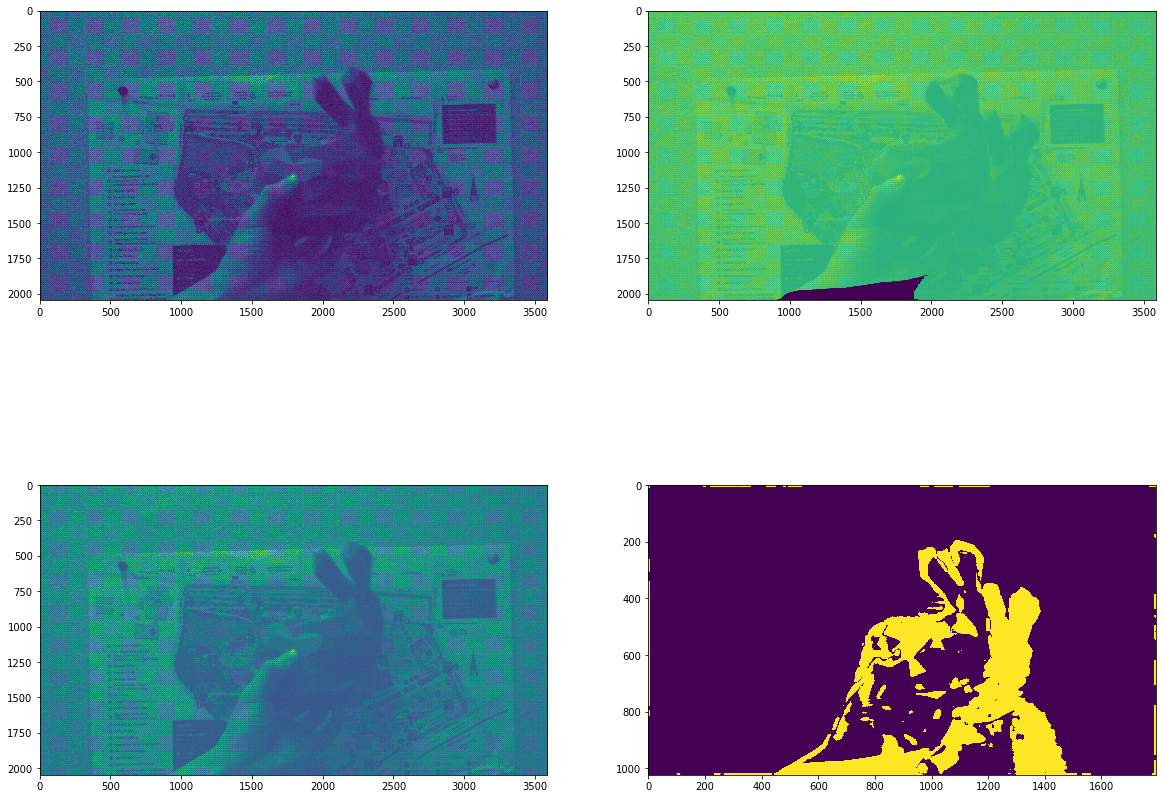

In [25]:
fig, ax = plt.subplots(2, 2, figsize=(20, 16))
ax[0][0].imshow(ref)
ax[0][1].imshow(alt)
ax[1][0].imshow(img)
ax[1][1].imshow(mask)
plt.show()

(1024, 1792)


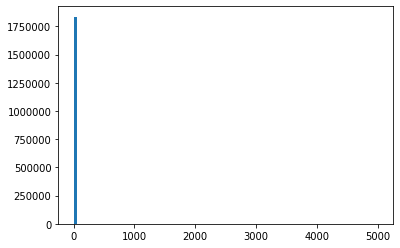

In [26]:
print(mask.shape)
plt.hist(mask.flatten(), bins = 100, range=(0, 5000))
plt.show()

In [27]:
print_stat('img', img)

img  shape:  (2048, 3584) dtype: float32
img stat: max: 77.0, min: 41.0, mean: 56.53963851928711, std: 3.573613166809082


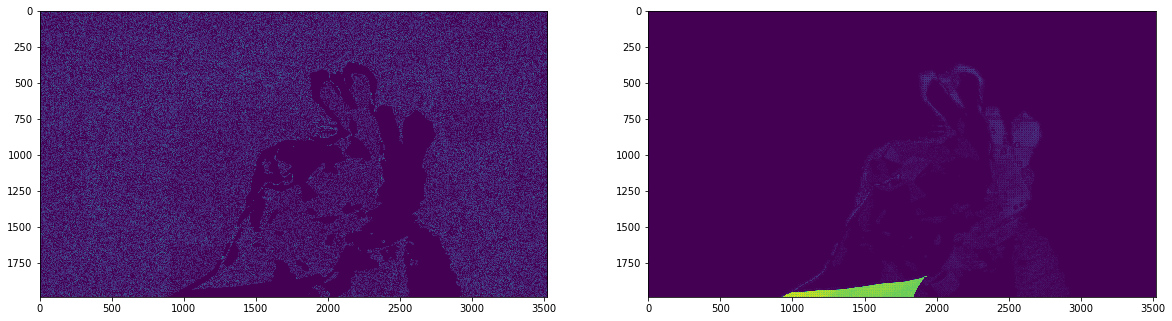

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(20, 16))
ax[0].imshow(np.abs(ref - img)[32:-32, 32:-32])
ax[1].imshow(np.abs(alt - img)[32:-32, 32:-32])
plt.show()

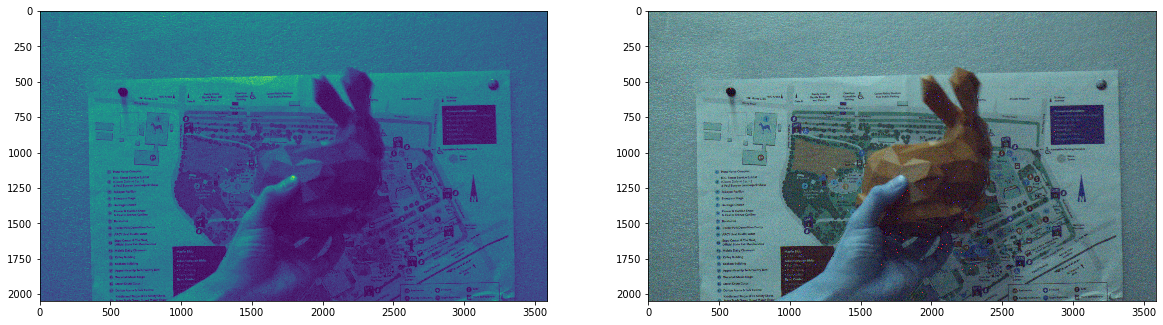

In [29]:
rIm_merge = np.clip(img - bk_lvl, 0,1023)

rgbIm_merge = demosaic(rIm_merge)
rgbIm_adj_merge = adjustColor(rgbIm_merge,rc = 1, bc = 1, gc = 0.7, gain=1.3, gamma = 1.25, contrast=1.5)
fig, ax = plt.subplots(1, 2, figsize=(20, 16))
ax[0].imshow(rIm_merge)
ax[1].imshow(rgbIm_adj_merge)
plt.show()

In [30]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
torch.save(model.state_dict(), 'model.pth')

Model's state_dict:
conv0.weight 	 torch.Size([4, 8, 15, 15])
conv1.weight 	 torch.Size([4, 4, 3, 3])
conv2.weight 	 torch.Size([4, 4, 3, 3])
conv3.weight 	 torch.Size([4, 4, 3, 3])
upconv1.weight 	 torch.Size([4, 4, 2, 2])
upconv2.weight 	 torch.Size([4, 4, 2, 2])
upconv3.weight 	 torch.Size([4, 4, 2, 2])
